In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device('cpu')  # Usamos CPU para este ejemplo

In [3]:
# Function to compute derivatives
def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

In [4]:
def Legendre(x: torch.Tensor, n: int) -> torch.Tensor:

    # Inicializa los dos primeros polinomios de Legendre
    legendre_polynomials = [torch.ones_like(x), x]

    # Calcula los polinomios de Legendre hasta el grado n
    for _ in range(2, n):
        # Coeficientes para la relación de recurrencia de los polinomios de Legendre
        a = (2 * _ - 1) / _
        b = (_ - 1) / _

        # Calcula el polinomio de Legendre de grado i usando la relación de recurrencia
        legendre_polynomial = a * x * legendre_polynomials[-1] - b * legendre_polynomials[-2]

        # Añade el polinomio de Legendre de grado i a la lista
        legendre_polynomials.append(legendre_polynomial)

    # Devuelve los polinomios de Legendre como un tensor de PyTorch
    return torch.stack(legendre_polynomials, dim=1)

class OrthogonalNeuralNetwork(nn.Module):
    
    def __init__(self, n: int, lb: float, ub: float):
        super(OrthogonalNeuralNetwork, self).__init__()
        self.n = n
        self.lb = lb
        self.ub = ub
        
        # Inicializa los coeficientes como parámetros del modelo que se aprenderán durante el entrenamiento
        self.weights = torch.nn.Parameter(torch.zeros(n, dtype=torch.float32))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normaliza la entrada
        x = 2 * (x - self.lb) / (self.ub - self.lb) - 1

        # Calcula los polinomios de Legendre hasta el grado especificado
        legendre_polynomials = Legendre(x, self.n)

        # Realiza una combinación lineal de los polinomios de Legendre seleccionados utilizando los coeficientes aprendidos
        return torch.matmul(legendre_polynomials, self.weights) 

In [70]:
omega = 1.0
lb = -2.0 * torch.pi
ub = 2.0 * torch.pi
x = torch.linspace(lb, ub, 3000, dtype=torch.float32, requires_grad=True).to(device)
model = OrthogonalNeuralNetwork(20, lb, ub).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'El modelo tiene {num_params} parámetros.')

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(),
                                lr=1,
                                max_iter=10_000,
                                max_eval=10_000,
                                tolerance_grad=1e-9,
                                history_size=50,
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn=None)
 

# Definir la función de cierre
iter_count=0
def closure():
    global iter_count
    iter_count+=1
    optimizer.zero_grad()
    y_pred = model(x) 
    y_t = x*y_pred
    y_x = derivative(y_t, x, order=1)  
    residuo =  y_x - torch.cos(omega*x)
    loss = criterion(residuo,torch.zeros_like(residuo))
    #if iter_count % 100 == 0: 
    print(f'iter {iter_count}, loss: {loss.detach().numpy()}')
    loss.backward(retain_graph=True)
    return loss

# Función para entrenar el modelo
def train_model():
    start_time = time.time()
    #for epoch in range(epochs):
    optimizer.step(closure)
    end_time = time.time()
    y_pred = model(x) 
    y_t = x*y_pred
    y_x = derivative(y_t, x, order=1)  
    residuo =  y_x - torch.cos(omega*x)
    loss = criterion(residuo,torch.zeros_like(residuo))    
    print(f'Final loss: {loss.detach().numpy()}')
    print(f'Tiempo de entrenamiento: {end_time - start_time} segundos')

# Entrenar el modelo
train_model()

El modelo tiene 20 parámetros.
iter 1, loss: 0.500166654586792
iter 2, loss: 41.57526397705078
iter 3, loss: 0.4595823585987091
iter 4, loss: 0.4485720694065094
iter 5, loss: 0.3622280955314636
iter 6, loss: 0.33167821168899536
iter 7, loss: 0.27144843339920044
iter 8, loss: 0.39079776406288147
iter 9, loss: 0.23028229176998138
iter 10, loss: 0.21939770877361298
iter 11, loss: 0.18085260689258575
iter 12, loss: 0.15542347729206085
iter 13, loss: 0.17899355292320251
iter 14, loss: 0.12120496481657028
iter 15, loss: 0.1123487576842308
iter 16, loss: 0.09631849825382233
iter 17, loss: 0.08877193927764893
iter 18, loss: 0.06566355377435684
iter 19, loss: 0.045486826449632645
iter 20, loss: 0.056903187185525894
iter 21, loss: 0.030631031841039658
iter 22, loss: 0.029536068439483643
iter 23, loss: 0.02874119020998478
iter 24, loss: 0.027580784633755684
iter 25, loss: 0.024640297517180443
iter 26, loss: 0.020238403230905533
iter 27, loss: 0.014024347066879272
iter 28, loss: 0.0084260683506727

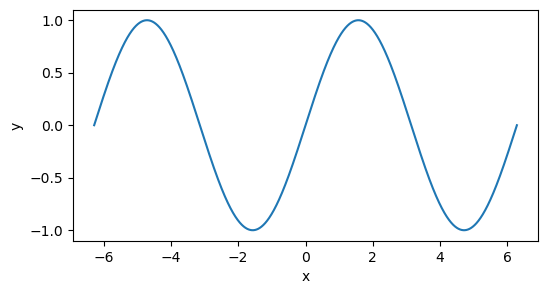

In [71]:
x = torch.linspace(lb, ub, 3000, dtype=torch.float32, requires_grad=True).to(device)
with torch.no_grad():
    y_pred = model(x)
y_pred = x*y_pred  
# Convertir tensores a numpy para visualización
x = x.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()

# Graficar los resultados
plt.figure(figsize=(6, 3))
plt.plot(x, y_pred)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.show()

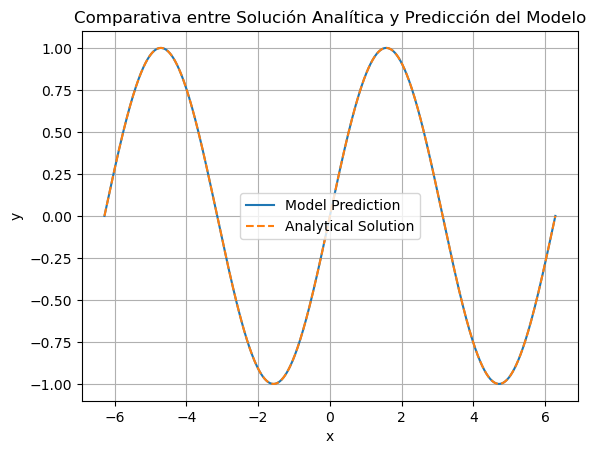

In [72]:
# Define the analytical function
def analytical(x):
    return np.sin(omega*x)/omega

x_values = np.linspace(lb, ub, 3000)

# Calculate y_pred using your model
x_tensor = torch.tensor(x_values, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(x_tensor)
y_pred = x_tensor * y_pred

# Convert tensors to numpy arrays for visualization
x_values = x_values
y_pred = y_pred.cpu().detach().numpy()

# Calculate analytical values for comparison
y_analytical = analytical(x_values)

# Plot the results
plt.plot(x_values, y_pred, label='Model Prediction')
plt.plot(x_values, y_analytical, label='Analytical Solution', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparativa entre Solución Analítica y Predicción del Modelo')
plt.legend()
plt.grid(True)
plt.show()


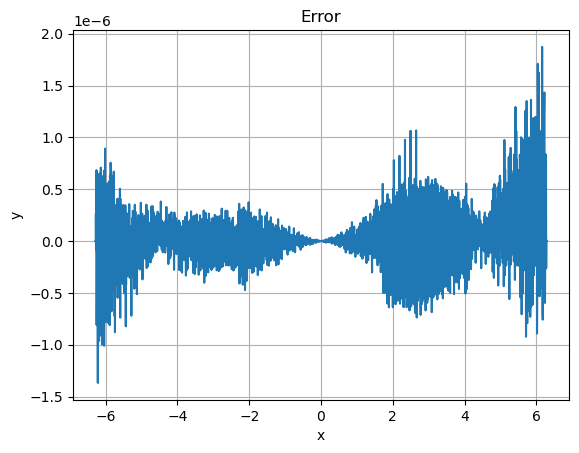

In [73]:
# Plot the results
plt.plot(x_values, y_analytical-y_pred)
plt.xlabel('x')
plt.ylabel('y')
#plt.ylim([-0.001,0.001])
plt.title('Error')
plt.grid(True)
plt.show()

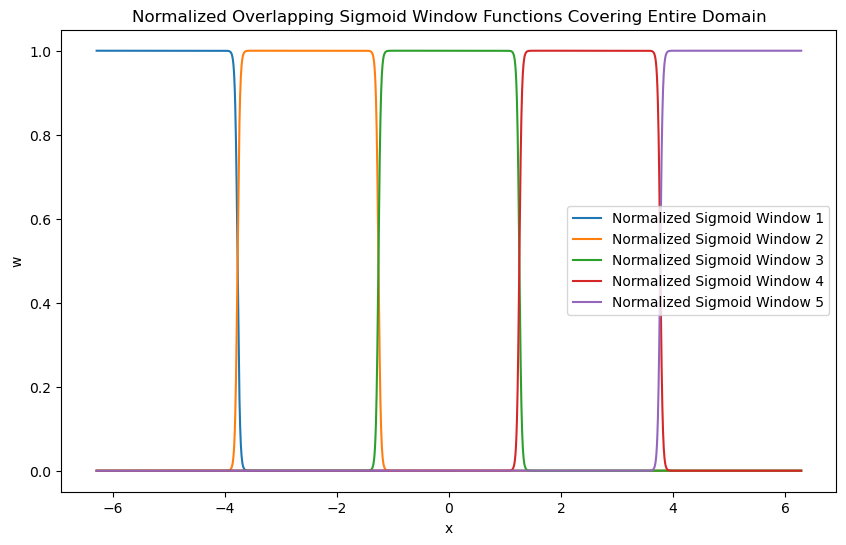

In [79]:
import torch
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(xmin, xmax, wmin, wmax, x, tol=1e-5):
    t = torch.log(torch.tensor((1-tol)/tol))
    mu_min, sd_min = xmin + wmin/2, wmin/(2*t)
    mu_max, sd_max = xmax - wmax/2, wmax/(2*t)
    ws = torch.nn.functional.sigmoid((x-mu_min)/sd_min) * torch.nn.functional.sigmoid((mu_max-x)/sd_max)
    return ws

# Define the domain range and number of windows
domain_start, domain_end = -2*torch.pi, 2*torch.pi
num_windows = 5

# Calculate the window width and spacing
total_width = domain_end - domain_start
window_width = total_width / num_windows
overlap = 1.0  # Adjust overlap as needed

# Adjust the parameters to cover the entire domain with 5 equally spaced windows
windows = [(domain_start + i * window_width, domain_start + (i + 1) * window_width, overlap, overlap) for i in range(num_windows)]

x_values = torch.linspace(domain_start, domain_end, 3000)  # Generate 1000 points between -2*pi and 2*pi

# Compute sigmoid values for each window
sigmoid_values = [sigmoid(xmin, xmax, wmin, wmax, x_values) for xmin, xmax, wmin, wmax in windows]

# Normalize the sigmoid values so their sum equals 1 at any given x
normalized_sigmoids = torch.stack(sigmoid_values) / torch.stack(sigmoid_values).sum(0)

plt.figure(figsize=(10, 6))

# Plot each normalized sigmoid window
for i, w_values in enumerate(normalized_sigmoids, start=1):
    plt.plot(x_values.numpy(), w_values.numpy().squeeze(), label=f'Normalized Sigmoid Window {i}')

plt.xlabel('x')
plt.ylabel('w')
plt.title('Normalized Overlapping Sigmoid Window Functions Covering Entire Domain')
plt.legend()
plt.show()

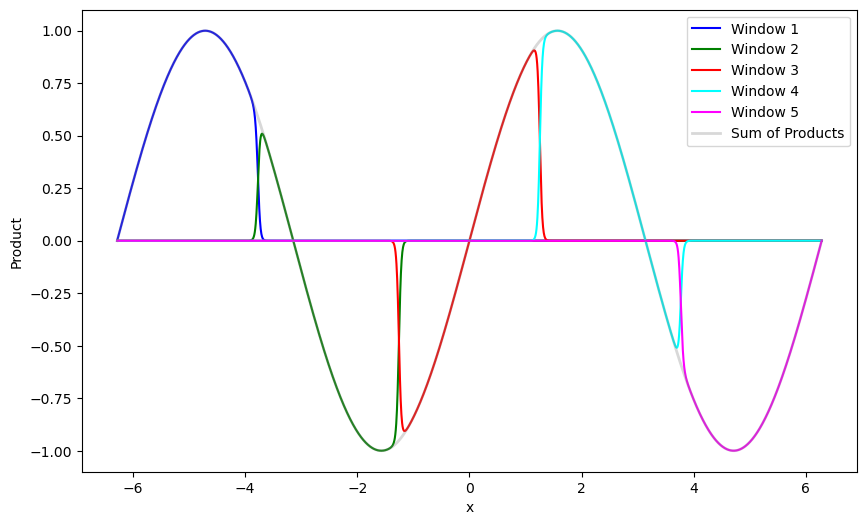

In [100]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta']  # Define una lista de colores
y_analytical_tensor = torch.tensor(y_analytical, dtype=torch.float32)
sum_of_products = torch.zeros_like(y_analytical_tensor)

plt.figure(figsize=(10, 6))  # Crea una figura para las gráficas

# Itera sobre cada ventana, calcula el producto y grafica con un color diferente
for i in range(len(normalized_sigmoids)):
    product = normalized_sigmoids[i] * y_analytical_tensor  # Asegúrate de usar y_analytical_tensor aquí
    sum_of_products += product  # Acumula el producto en la suma
    plt.plot(x_values.numpy(), product.numpy().squeeze(), label=f'Window {i+1}', color=colors[i])

# Grafica la suma de los productos después de calcular todos los productos individuales
plt.plot(x_values.numpy(), sum_of_products.numpy().squeeze(), label='Sum of Products', color='gray', linewidth=2,alpha=0.3)

plt.xlabel('x')  # Etiqueta del eje x
plt.ylabel('Product')  # Etiqueta del eje y
#plt.title('Product of Normalized Sigmoids and y_analytical for Each Window')  # Título de la gráfica
plt.legend()  # Muestra la leyenda
plt.show()  # Muestra la gráfica